In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans      # K-Means
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer     # Elbow method 
from scipy.cluster.hierarchy import linkage, dendrogram  # hierarchical clustering
from sklearn.preprocessing import StandardScaler    
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering     # hierarchical clustering

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

import warnings 
warnings.simplefilter(action='ignore', category=Warning)

# Data Exploration

In [32]:
data = pd.read_csv("../../model_testing/UnBalancedData/Churn Prediction/bank_churn.csv")
data.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2795,2796,15665110,Helena,515,France,Female,25,7,79543.59,1,0,1,38772.82,0
3293,3294,15691863,Cody,751,France,Female,39,3,0.00,2,1,1,84175.34,0
9462,9463,15737385,Curtis,800,Spain,Female,46,6,0.00,2,1,0,171928.04,0
317,318,15666252,Ritchie,706,Spain,Male,42,9,0.00,2,1,1,28714.34,0
6207,6208,15665811,Parry,644,France,Male,33,9,141234.98,1,1,0,95673.05,0


In [33]:
data.drop(['RowNumber','CustomerId', 'Surname', 'Exited'],axis='columns',inplace=True)
data.sample(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
5974,773,France,Male,45,8,96877.21,1,1,1,113950.51
3111,623,Germany,Male,42,1,149332.48,2,1,0,100834.22
9913,718,France,Female,44,1,133866.22,1,0,1,139049.24
637,682,France,Male,48,1,138778.15,1,0,1,168840.23
1571,594,France,Male,23,5,156267.59,1,1,0,160968.44


In [34]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
Note: Categorical variables with numerical appearance are also included in categorical variables.

     parameters
     ------
         dataframe: dataframe
                 The dataframe from which variable names are to be retrieved
         cat_th: int, optional
                 class threshold for numeric but categorical variables
         car_th: int, optinal
                 class threshold for categorical but cardinal variables

     Returns
     ------
         cat_cols: list
                 Categorical variable list
         num_cols: list
                 Numeric variable list
         cat_but_car: list
                 Categorical view cardinal variable list

     Examples
     ------
         import seaborn as sns
         df = sns.load_dataset("iris")
         print(grab_col_names(df))


     notes
     ------
         cat_cols + num_cols + cat_but_car = total number of variables
         num_but_cat is inside cat_cols.
         The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [35]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [36]:
df = data.copy()

In [37]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
print(cat_cols)
print(num_cols)
print(cat_but_car)

['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
[]


In [38]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]
for col in binary_cols:
    df = label_encoder(df, col)

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 25 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [108]:
sc = StandardScaler()
X = sc.fit_transform(df[num_cols])
X = pd.DataFrame(X, columns=num_cols)
X.head()

,CreditScore,Age,Balance,EstimatedSalary
0,-0.326221,0.293517,-1.225848,0.021886
1,-0.440036,0.198164,0.117350,0.216534
2,-1.536794,0.293517,1.333053,0.240687
3,0.501521,0.007457,-1.225848,-0.108918
4,2.063884,0.388871,0.785728,-0.365276


# KMeans

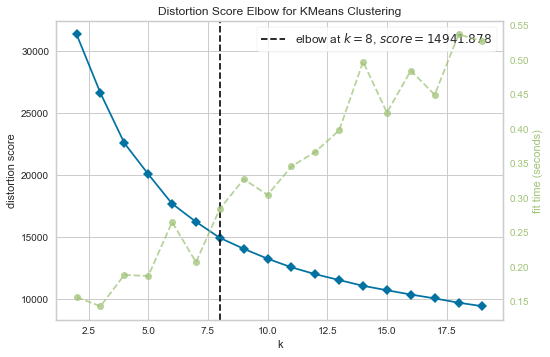

8

In [109]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(X)
elbow.show(block=True)

elbow.elbow_value_

In [110]:
kmeans = KMeans(n_clusters=elbow.elbow_value_, init='k-means++').fit(X)
kmeans.cluster_centers_  # Indicates the centers of clusters.

array([[-0.87624801, -0.1915514 ,  0.72827441,  0.8801761 ],
       [ 0.80708058, -0.25256131,  0.74312121, -0.87186602],
       [-1.13087343, -0.19464388, -1.18956113, -0.13594953],
       [ 0.79767163, -0.24558964,  0.71950668,  0.89259627],
       [ 0.04959202,  2.136211  ,  0.07227788, -0.09540055],
       [-0.81658109, -0.17539368,  0.7390895 , -0.86389593],
       [ 0.56236215, -0.30951859, -1.18522801, -0.91644861],
       [ 0.40465811, -0.26234531, -1.19701446,  0.97588801]])

In [111]:
clusters_kmeans = kmeans.labels_    # Indicates which observation the clusters belong to.
X["cluster"] = clusters_kmeans   # We added a variable named cluster_no to X.
X.head()

,CreditScore,Age,Balance,EstimatedSalary,cluster
0,-0.326221,0.293517,-1.225848,0.021886,2
1,-0.440036,0.198164,0.117350,0.216534,0
2,-1.536794,0.293517,1.333053,0.240687,0
3,0.501521,0.007457,-1.225848,-0.108918,6
4,2.063884,0.388871,0.785728,-0.365276,1


# Hierarchical Clustering

In [112]:
X.drop(columns=["cluster"], inplace=True)

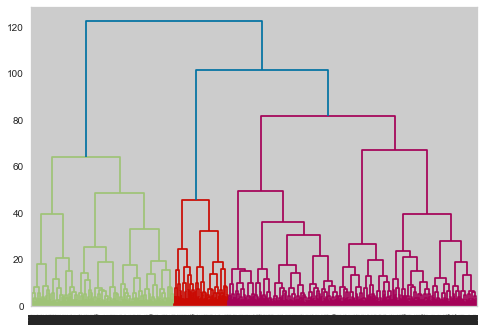

In [113]:
linkage_matrix = linkage(X, method='ward')
# Create the dendrogram
dend = dendrogram(linkage_matrix)
# Show the dendrogram
plt.show()

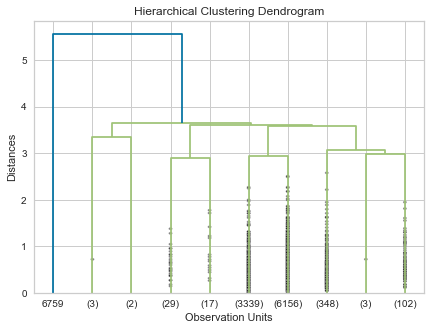

In [115]:
hc_average = linkage(X, "average")  # We created a connection matrix with the average method.
plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_average, truncate_mode="lastp", p=10, show_contracted=True, leaf_font_size=10)
plt.show()

In [120]:
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clusters_hc = hc.fit_predict(X)
X["cluster_hc"] = clusters_hc

In [121]:
X["cluster_hc"].value_counts() / len(X) * 100

0    55.83
1    32.12
2    12.05
Name: cluster_hc, dtype: float64

# DBSCAN

In [95]:
X.drop(columns=["cluster_hc"], inplace=True)

In [96]:
from sklearn.cluster import DBSCAN

In [104]:
dbscan = DBSCAN(eps=0.8, min_samples=100)
clusters = dbscan.fit_predict(X)
print(clusters)

[0 2 1 ... 0 1 1]


In [105]:
X["cluster_db"] = clusters

In [106]:
X["cluster_db"].value_counts() / len(X) * 100

 1    32.94
-1    32.00
 0    21.06
 2    12.78
 3     1.22
Name: cluster_db, dtype: float64